In [144]:
import torch
from torch import Tensor
torch.set_grad_enabled(False)
from torch import *

from torch import nn
from torch import optim
from torch.nn import functional as F
import math
import time #used for benchmarking

In [111]:
import matplotlib 
from matplotlib import pyplot as plt

### Readme pls :)  
All layers follow the same principle:  
* **forward**: return the layer's output if given some input. Additionally, Linear layers will store the inputted data to do the backward pass.
* **backward**: compute the layer's gradients given the successor layers' gradient. Linear layer will also store the next layer gradient to do its update step.
* **step**: given an step size eta, will update the Linear weights and biases accordingly. Do nothing on activation layers.
* **param** (utility): return layer's parameter in a list. Activation layers return an empty list while Linear layers return its weight and biases parameter.

# Activation function

In [112]:
class ActivationFunc(object):
    def forward(self,x):
        self.x = x
    
    def backward(self, *output_grad):
        pass
    
    def requires_grad(self):
        return False
    
    def zero_grad(self):
        self.x= 0
    
    def param(self):
        return []
        

In [113]:
class ReLU(ActivationFunc):        
    
    def forward(self, x):
        super().forward(x)
        return (x > 0) * x
    
    def backward(self, *output_grad):
        """first item of output_grad should be the derivative of the previous layer"""
        dl_dr = (self.x > 0) * 1.0 * output_grad[0]
        return dl_dr

In [114]:
class Sigmoid(ActivationFunc):
    
    def sigmoid(self, x):
        return 1 / (1 + torch.exp(-x))
    
    def forward(self, x):
        super().forward(x)
        return self.sigmoid(x)
    
    def backward(self, *output_grad):
        """first item of output_grad should be the derivative of the previous layer"""
        dl_ds = (self.sigmoid(self.x) * (1 - self.sigmoid(self.x))) * output_grad[0]
        return dl_ds

In [115]:
class LeakyReLU(ActivationFunc):        
    
    def lrelu(self, x, alpha=0.01):
        return torch.max(alpha * x, x)
    
    def forward(self, x, alpha=0.01):
        super().forward(x)
        return self.lrelu(x)
    
    def backward(self, *output_grad,alpha=0.01):
        """first item of output_grad should be the derivative of the previous layer"""
        inter = (self.x >=0) + (self.x < 0)*alpha
        dl_dlr =  inter * output_grad[0]
        return dl_dlr

In [116]:
class Tanh(ActivationFunc):
    
    def forward(self, x):
        super().forward(x)
        return (2 / (1 + (-2*x).exp())) - 1
    
    def backward(self, *output_grad):
        """first item of output_grad should be the derivative of the previous layer"""
        dl_dt = (1 - self.forward(self.x)**2) * output_grad[0]
        return dl_dt

In [117]:
class ELU(ActivationFunc):        
    
    def forward(self, x, alpha=0.01):
        #self.x = x
        super().forward(x)
        return (self.x >0)*x + (self.x <= 0)*alpha*(torch.exp(self.x) -1)
    
    def backward(self, *output_grad,alpha=0.01):
        """first item of output_grad should be the derivative of the previous layer"""
        inter = (self.x >0) + (self.x <= 0)*alpha*torch.exp(self.x)
        dl_del =  inter * output_grad[0]
        return dl_del

In [118]:
class SoftMax(ActivationFunc):
    
    def softmax(self, x):
        expo = torch.exp(x - torch.max(x))
        return expo /torch.sum(expo,0)
    
    def forward(self, x):
        super().forward(x)
        #self.x = x
        return self.softmax(x)
    
    def backward(self, *output_grad):
        """first item of output_grad should be the derivative of the previous layer"""
        
        s = self.softmax(self.x)
        dl_dsm = s * (1 - s)
        dl_dsm = dl_dsm * output_grad[0]
        return dl_dsm

# Layers

In [119]:
class Linear(object):
    
    def __init__(self, in_size, out_size, init = None):
        if init is None:
            std = 1
        elif init is 'Xavier':
            std = math.sqrt(1.0 / (in_size + out_size))
        elif init is 'He':
            std = math.sqrt(2.0 / in_size)
            
        self.weights = torch.empty(in_size, out_size).normal_(std = std)
        self.bias = Tensor(1, out_size).normal_()
        self.x = 0
        self.dx1 = 0
        
    def forward(self, x):
        self.x = x
        #print('Forward Linear', (x @ self.weights) + self.bias)
        return (x @ self.weights) + self.bias
    
    def backward(self, *output_grad):
        #print('Backward Linear')
        """first item of output_grad should be the derivative of the previous layer"""
        self.dx1 = output_grad[0]
        self.dw = self.x.t() @ self.dx1
        #print(self.db.shape)
        self.db = (self.dx1).sum(axis=0)
        #print(self.db.shape)
        return output_grad[0] @ self.weights.t()
    
    def grad(self):
        dw = self.x.t() @ self.dx1
        db = self.dx1
        return [dw, db]
    
    def step(self, eta):
        #print(self.weights)
        dw = self.x.t() @ self.dx1
        db = self.dx1
        self.weights.add_(-eta * self.dw)

        #if len(db.shape) > 1:
            #self.bias.add_(-eta * db.sum(axis=0))
        #else:
            #print('b')
        self.bias.add_(-eta * self.db)
        return
    
    def requires_grad(self):
        return True
    
    def zero_grad(self):
        self.dw =0
        self.db = 0
        
    def param(self):
        return [[self.weights, self.dw], [self.bias, self.db]]

In [120]:
class Sequential(object):
    
    def __init__(self, *layers):
        self.layers = layers
    
    def forward(self, x):
        y = x
        for layer in self.layers:
            y = layer.forward(y)        
        return y
    
    def backward(self, *output_grad):
        d_list = [output_grad[0]]
        
        # We iterate from last layer to first layer
        # Each layer's gradient is then prepended to the gradient list
        for layer in self.layers[::-1]:
            d_list.insert(0, layer.backward(*d_list))            
        return d_list
    
    def step(self, eta):
        for layer in self.layers:
            if layer.requires_grad():
                layer.step(eta)
    
    def zero_grad(self):
        for layer in self.layers:
            layer.zero_grad()
            
    def param(self):
        return [layer.param() for layer in self.layers]

# Losses

In [121]:
def softmax(x):
        a,_ = torch.max(x, dim = 1)
        expo = torch.exp(x - a.view(-1,1))
        #print(expo.shape)
        #print(torch.sum(expo, dim = 1).shape)
        return expo /torch.sum(expo, dim = 1).view(-1,1)

In [122]:
class Loss(object):
    def loss(self,predicted,target):
        pass
    def dloss(self,predicted,target):
        pass

In [123]:
class MSELoss(Loss):
    def loss(self,predicted, target):
        return ((predicted - target)**2).mean()
    
    def dloss(self,predicted, target):
        return 2 * (predicted - target)/(len(predicted))

In [124]:
class CrossEntropyLoss(Loss):
    
    def loss(self,predicted, target):
        a,_ = torch.max(predicted, dim = 1)

        #loss = - (predicted*target).sum(dim=1) + torch.log(predicted.exp().sum(dim = 1))
        loss = - (predicted*target).sum(dim = 1)
        loss += a
        loss += torch.log((predicted - a.view(-1,1)).exp().sum(dim=1))        
        return loss.mean(dim = 0)
    
    def dloss(self,predicted, target):
        #print((predicted == target)*1.0)
        dloss = softmax(predicted) - target
        return dloss/len(predicted)

# Optimizer

In [146]:
class Optimizer(object):
    def __init__(self, eta, model):
        self.eta = eta
        self.model = model
        
    def step(self):
        pass

class SGD(Optimizer):
    
    def __init__(self, eta, model, weight_decay = 0):
        super().__init__(eta, model)
        self.weight_decay = weight_decay
        
    def step (self):
        for layer in self.model.layers:
            if layer.requires_grad():
                for param in layer.param():
                    param[0].add_(-self.eta * param[1] - self.weight_decay * param[0])    

# Training

In [126]:
def compute_error_ratio(predicted, classes):
    #predicted_classes = (predicted > 0.5) * 1
    _, predicted_classes = torch.max(predicted, 1)
    _, labels = torch.max(classes, 1)
    e = (predicted_classes - labels).float().abs().mean()
    return e

In [127]:
def generate_data(nb):
    train_input = torch.rand(nb,2)
    train_target = torch.empty(nb, dtype=torch.long)
    train_target = train_input.sub(0.5).pow(2).sum(1).sub(1 / (2*math.pi)).sign().add(1).div(2).float().view(-1,1)
    return train_input, train_target

In [128]:
def convert_to_one_hot_labels(target):
    tmp = torch.Tensor().new_zeros(target.size(0), int(target.max().item()) + 1)
    tmp.scatter_(1, target.view(-1, 1).long(), 1.0)
    return tmp

In [129]:
train_input, train_target = generate_data(1000)
test_input, test_target = generate_data(1000)

In [130]:
train_target = convert_to_one_hot_labels(train_target)
test_target = convert_to_one_hot_labels(test_target)

In [183]:
def train_model(model, train_input, train_target, mini_batch_size=100, eta=0.01, reg = 0.001, iterations=1000):
    
    optimizer = SGD(eta = eta, model = model, weight_decay = reg)
    training_loss = torch.empty((iterations,1)) #Training loss over epochs
    training_error = torch.empty((iterations,1)) #Training error over epochs
    criterion = MSELoss()
    for i in range(iterations):
        for inputs, targets in zip(train_input.split(mini_batch_size),
                                  train_target.split(mini_batch_size)):
        
            predicted = model.forward(inputs)
            loss = criterion.loss(predicted, targets)
            e = compute_error_ratio(predicted, targets)
        
            dloss = criterion.dloss(predicted, targets)
        
            model.backward(dloss)
            #model.step(eta)
            optimizer.step()
            model.zero_grad()
        
        #if i%100 == 0:
            #print("Training Loss at {:04d}: {:3.3f} with {:02.2f}% of error".format(i, loss, e*100), end = '\r')
        training_loss[i] = loss
        training_error[i] = e
        print(i, loss.item(), end = '\r')

    return training_loss, training_error

In [192]:
def init_weights(m):
    if type(m) == nn.Linear:
        torch.nn.init.normal_(m.weight)
        m.bias.data.normal_()

def train_model_torch(model, train_input, train_target, mini_batch_size=100, eta=0.01, reg = 0.001, iterations=1000):
    
    torch.set_grad_enabled(True)
    model.apply(init_weights)
    optimizer = SGD(eta = eta, model = model, weight_decay = reg)
    training_loss = torch.empty((iterations,1)) #Training loss over epochs
    training_error = torch.empty((iterations,1)) #Training error over epochs
    criterion = nn.MSELoss()
    optimizer = optim.SGD(model.parameters(), lr=0.01, weight_decay = reg)

    for i in range(iterations):
        for b in range(0, train_input.size(0), mini_batch_size):
            optimizer.zero_grad()
            predicted = model(train_input.narrow(0, b, mini_batch_size))
            loss = criterion(predicted, train_target.narrow(0, b, mini_batch_size))
            e = compute_error_ratio(predicted, train_target.narrow(0, b, mini_batch_size))
            loss.backward()
            optimizer.step()

        #if i%100 == 0:
            #print("Training Loss at {:04d}: {:3.3f} with {:02.2f}% of error".format(i, loss, e*100), end = '\r')
        training_loss[i] = loss
        training_error[i] = e
        print(i, loss.item(), end = '\r')
        
    torch.set_grad_enabled(False)
    return training_loss, training_error

In [193]:
def evaluate_model(rounds=10, iterations = 1000, is_torch = False, lr = 0.01, reg = 0.001):

    test_error = torch.empty((rounds,1))
    train_error = torch.empty((rounds,1))
    training_loss = torch.empty((rounds,iterations))
    for k in range(rounds):
        model = create_model(is_torch)
        
        if is_torch: model.apply(init_weights)
        num_samples = 1000
        
        #Generate data
        train_input, train_target = generate_data(1000)
        test_input, test_target = generate_data(1000)
        
        train_target = convert_to_one_hot_labels(train_target)
        test_target = convert_to_one_hot_labels(test_target)
        
        if is_torch:
            loss, _ = train_model_torch(model, train_input, train_target, iterations=iterations, eta = lr, reg = reg)
            predicted_test = model(test_input)
            predicted_train = model(train_input)
        else:
            loss,_ = train_model(model, train_input, train_target, iterations = iterations, reg = reg)
            predicted_test = model.forward(test_input)
            predicted_train = model.forward(train_input)
        
        
        err_test = compute_error_ratio(predicted_test, test_target)
        err_train = compute_error_ratio(predicted_train, train_target)
        
        #print(loss.shape)
        training_loss[k] = loss.t()
        train_error[k] = err_train
        test_error[k] = err_test
        
    return (torch.mean(test_error).item(), torch.std(test_error).item(), torch.mean(train_error).item(), torch.std(train_error).item(), torch.mean(training_loss, axis = 0))

Comparison with Pytorch

In [194]:
def create_model(torch, nb_hidden = 25):
    if torch :
        return nn.Sequential(nn.Linear(2,nb_hidden), nn.ReLU(), nn.Linear(nb_hidden,nb_hidden), nn.Tanh(), 
                           nn.Linear(nb_hidden,nb_hidden), nn.Sigmoid(), nn.Linear(nb_hidden,2))
    else:
        return Sequential(Linear(2,nb_hidden), ReLU(), Linear(nb_hidden,nb_hidden), Tanh(),
                          Linear(nb_hidden,nb_hidden), Sigmoid(), Linear(nb_hidden,2))
    

Custom framework with 10 rounds in 16.417131547099416:111486435 0.03806956112384796 0.037609148770570755 0.048460718244314194 0.04135759919881821 0.02793887071311474 0.04429428651928902 0.04339282587170601
   training mean accuracy: 0.978
   training std accuracy: 0.006
   test mean accuracy: 0.975
   test stdv accuracy: 0.007211



The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


Pytorch framework with 10 rounds in 12.02842227930014:
   training mean accuracy: 0.979
   training std accuracy: 0.005
   test mean accuracy: 0.972
   test stdv accuracy: 0.007483



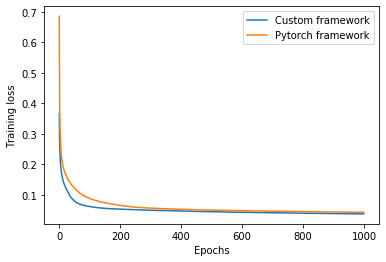

In [195]:
dict_model = {
    "Custom framework" : {"torch" : False},
    "Pytorch framework" : {"torch" : True},
}
rounds= 10
plt.figure()
for key in dict_model.keys():
    is_torch = dict_model[key]["torch"]
    
    start = time.perf_counter()
    mean , std, mean_train, std_train, loss = evaluate_model(rounds, is_torch = is_torch, reg = 0)
    avg_time = (time.perf_counter() - start) / rounds
    mean = 1- mean
    mean_train = 1 - mean_train
    plt.plot(loss, label = "{}".format(key))
    print("{} with {} rounds in {}:".format(key, rounds, avg_time))
    print("   training mean accuracy: {:.3f}".format(mean_train))
    print("   training std accuracy: {:.3f}".format(std_train))
    print("   test mean accuracy: {:.3f}".format(mean))
    print("   test stdv accuracy: {:.6f}".format(std))
    print()
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Training loss')
plt.savefig("comparison_with_mseloss.eps")